# 関数のテスト

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import calc_variogram as variogram
import kriging_est as kriging

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_raw.csv')
data['price'] = np.log(data.price)

## Step1: OLSから残差を算出

In [4]:
# 前処理
x = data[['station', 'tokyo']]
y = data['price']

In [5]:
step1 = sm.OLS(y, x)
step1_res = step1.fit()
resid = step1_res.resid

## Step2: 残差からvariogramを推定

In [6]:
# 前処理
resid = pd.DataFrame(resid, columns=['residuals'])
resid = data[['px', 'py']].join(resid)
resid = resid.values

In [7]:
resid

array([[ 1.39362310e+02,  3.57338500e+01, -2.19762641e+00],
       [ 1.39363027e+02,  3.56540780e+01, -2.02881591e+00],
       [ 1.39367082e+02,  3.56598590e+01, -1.56820750e+00],
       [ 1.39369003e+02,  3.56455460e+01, -1.44905066e+00],
       [ 1.39371526e+02,  3.56473230e+01, -1.57131189e+00],
       [ 1.39373562e+02,  3.57275950e+01, -1.24026561e+00],
       [ 1.39374415e+02,  3.56732410e+01, -1.53129022e+00],
       [ 1.39374691e+02,  3.56539720e+01, -1.29646077e+00],
       [ 1.39375802e+02,  3.56629740e+01, -8.90992590e-01],
       [ 1.39377419e+02,  3.56685930e+01, -1.07634726e+00],
       [ 1.39379504e+02,  3.56789730e+01, -1.39733678e+00],
       [ 1.39379862e+02,  3.56816580e+01, -1.50014008e+00],
       [ 1.39380375e+02,  3.56544240e+01, -8.21454976e-01],
       [ 1.39380871e+02,  3.57220070e+01, -1.51691262e+00],
       [ 1.39382431e+02,  3.56486010e+01, -8.36495633e-01],
       [ 1.39382461e+02,  3.56530610e+01, -9.26234389e-01],
       [ 1.39385678e+02,  3.56714310e+01

In [8]:
vario = variogram.get_diff(resid)

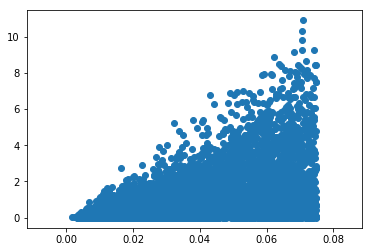

In [9]:
plt.scatter(vario[0], vario[1])

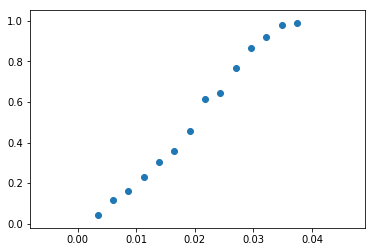

In [10]:
e_vario, lag = variogram.emp_variogram(vario, 14)
plt.scatter(e_vario[0], e_vario[1])

[ 0.00000000e+00  1.00000000e+02 -9.31287719e-02  3.05753574e+01]
[1.00000000e+00 1.00000000e+02 4.02229290e-02 1.15936237e+00
 2.74533641e-02]
[2.00000000e+00 1.00000000e+02 5.92766230e-28 1.00000000e+02
 3.69238764e+00]
[3.00000000e+00 1.00000000e+02 1.01603614e-33 9.99973584e+01
 5.55954509e+00]
[0.         0.00457977 0.00915954 0.01373932 0.01831909 0.02289886
 0.02747863 0.03205841 0.03663818 0.04121795]
[0.         0.00457977 0.00915954 0.01373932 0.01831909 0.02289886
 0.02747863 0.03205841 0.03663818 0.04121795] 1.159362365092936 0.02745336407021383
[1.00000000e+00 1.00000000e+02 4.02229290e-02 1.15936237e+00
 2.74533641e-02]


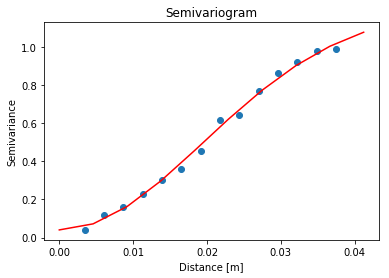

In [11]:
param, lag, fig = variogram.auto_vario(vario, 14)

In [12]:
print(param)

[1.00000000e+00 1.00000000e+02 4.02229290e-02 1.15936237e+00
 2.74533641e-02]


## Step3: gls
- 共分散関数を推定
    - 観測値間の距離行列を作成
    - 推定したパラメータから$\hat{C}(0)$を推定
    - 正定値になるように処理を加える(数学的な根拠は不明, Rではどのように処理している?)
- 共分散関数の推定量を用いてgls

In [13]:
distance_mat = kriging.calc_distance_matrix(data, ['px', 'py'])

In [14]:
efrange, c0 = kriging.calc_c0(param, distance_mat)

In [15]:
print(efrange)

0.1499187183409662


In [16]:
print(c0)

0.511292448046795


In [17]:
# 距離行列と関数形から共分散関数を求める
# reg=Trueなので正定値化処理を加えている
covariance_mat = kriging.est_covariance_matrix(distance_mat, param, c0)

0.648169917046143


In [18]:
print(covariance_mat)

[[1.15946237 0.9194825  0.94897167 ... 0.53510927 0.54800759 0.5657438 ]
 [0.9194825  1.15946237 1.15725855 ... 0.78922928 0.78639522 0.77876343]
 [0.94897167 1.15725855 1.15946237 ... 0.80240627 0.80150167 0.79672904]
 ...
 [0.53510927 0.78922928 0.80240627 ... 1.15946237 1.15830736 1.15265356]
 [0.54800759 0.78639522 0.80150167 ... 1.15830736 1.15946237 1.15691078]
 [0.5657438  0.77876343 0.79672904 ... 1.15265356 1.15691078 1.15946237]]


In [19]:
# 重みを用いてgls
# statsmodelsのresultクラスが返る
res, resid = kriging.do_gls(y, x, covariance_mat)

In [20]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.275
Model:                            GLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     23.86
Date:                Thu, 11 Apr 2019   Prob (F-statistic):           1.64e-09
Time:                        15:56:32   Log-Likelihood:                 54.586
No. Observations:                 128   AIC:                            -105.2
Df Residuals:                     126   BIC:                            -99.47
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
station      -21.8741      3.269     -6.690      0.000     -28.344     -15.404
tokyo         33.1966     18.766      1.769      0.079      -3.941      70.334
==============================================================================
Omnibus:                        1.538   Durbin-Watson:                   2.281
Prob(Omnibus):                  0.464   Jarque-Bera (JB):                1.069
Skew:                           0.170   Prob(JB):                        0.586
Kurtosis:                       3.291   Cond. No.                         5.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step4: kirigng
- 観測地点と予測地点の間の共分散関数$c_*$を作成する
    - 距離行列作成
    - 共分散関数にあてはめる
- 足し合わせ $\hat{Y}(s_o) = X(s_0)\hat{\beta}_{gls} + c_*'\hat{\Sigma}^{-1}(Y - X\beta)$

In [21]:
# 前処理
mdat = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_pred.csv')
mdat.head()

,px,py,price,station,tokyo
0,139.402984,35.767626,NaN,0.017537,0.374249
1,139.407036,35.767626,NaN,0.013571,0.370307
2,139.411089,35.767626,NaN,0.009675,0.366367
3,139.439457,35.767626,NaN,0.001584,0.338865
4,139.394878,35.763700,NaN,0.026327,0.381271


In [22]:
mpoints = mdat[['px', 'py']].values
mexog = mdat[['station', 'tokyo']].values

In [23]:
points = data[['px', 'py']].values

In [24]:
# 距離行列作成
new_dist_mat = kriging.calc_distance_new_data(mpoints, points)

In [25]:
# 距離行列と関数型から共分散行列を推定
# reg=Falseを指定して正定値処理をスキップ(正方行列でないのでエラーを防ぐ)
c_mat = kriging.est_covariance_matrix(new_dist_mat, param, c0, reg=False)

In [26]:
fitted_val = kriging.put_pred_val(res, mexog)

In [27]:
kriging_val = kriging.do_kriging(fitted_val, c_mat, covariance_mat, resid)

## Rでの結果との比較

In [28]:
res_inR = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/krig_res_R.csv')
res_inR = res_inR.iloc[:, 1:-2]

Text(0, 0.5, 'pred by Python')

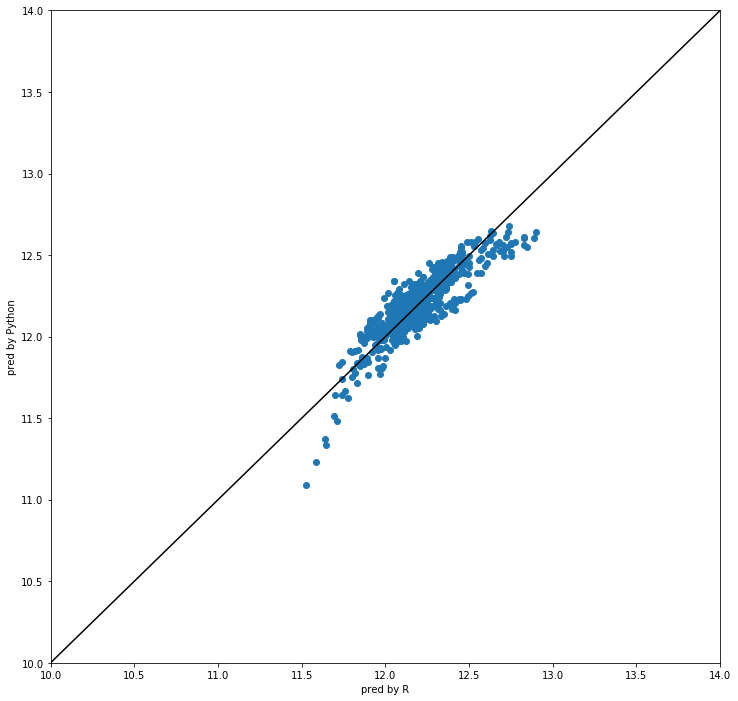

In [29]:
res_fig = plt.figure(figsize=(12, 12))
res_ax = res_fig.add_subplot(1, 1, 1)
res_ax.scatter(res_inR['var1.pred'], kriging_val)
res_ax.plot(np.linspace(10, 14, 1000), np.linspace(10, 14, 1000), color='black')
res_ax.set_xlim(10, 14)
res_ax.set_ylim(10, 14)
res_ax.set_xlabel('pred by R')
res_ax.set_ylabel('pred by Python')
# Rとの結果とそこそこ整合的になった?

In [57]:
res_fig.savefig('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/plot/kriging_est_func_res2.png')

# Todo
- 共分散関数の$\hat{C}(0)$の推定が指数型分布しか対応していないので、ガウス型などにも拡張
    - 線形型の場合はユーザーが指定するように設定しているが、それで良いのか確認
- クラス化してコードを簡略化